In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Load the data
df = pd.read_csv("../results/metric_human_eval/llama3.3_manual_eval.csv")
#df2 = pd.read_csv("../results/ragchecker/human_eval_cvpr_outputs.csv")

# Define the metrics to evaluate
#metrics = ["bert_score", "mca_v2", "mca_v2_no_context","perplexity_accuracy", "mca_v2_cot", "mca_v2_cot_no_context", "da_cot",
#           "da_cot_10","da_cot_ex","da_cot_steps","da_cot_ragas","mca_da_cot"] 
metrics = ["da_cot_10_score", "da_cot_10", "precision"] # ["recall", "precision", "f1"]

# add df2 metrics columns to df
try:
    for metric in metrics:
        if metric in df2.columns:
            df[metric] = df2[metric]
except Exception as e:
    print(f"Could not add df2 metrics to df: {e}")

# df["majority_vote"] = df[metrics].mode(axis=1)[0] 
# metrics = metrics + ["majority_vote"]

# Initialize a dictionary to store evaluation metrics
evaluation_results = {}

Could not add df2 metrics to df: name 'df2' is not defined


In [8]:
def evaluate_metric(metric, metric_series, verbose=True):
    # Calculate confusion matrix
    cm = confusion_matrix(df["human_eval"], metric_series)
    
    # Plot confusion matrix with seaborn
    if verbose:
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {metric}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
    
    # Calculate precision, recall, and F1 score for both classes (0 and 1)
    precision = precision_score(df["human_eval"], metric_series, average=None)
    recall = recall_score(df["human_eval"], metric_series, average=None)
    f1 = f1_score(df["human_eval"], metric_series, average=None)
    accuracy = accuracy_score(df["human_eval"], metric_series)

    # Pearson correlation coefficient
    pearson_corr = df["human_eval"].corr(metric_series, method='pearson')
    
    # Store the results in the dictionary
    results = {
        "Precision (Class 0)": precision[0],
        "Precision (Class 1)": precision[1],
        "Recall (Class 0)": recall[0],
        "Recall (Class 1)": recall[1],
        "F1 Score (Class 0)": f1[0],
        "F1 Score (Class 1)": f1[1],
        "F1 Score Mean": (f1[0]+f1[1])/2,
        "Pearson Corr": pearson_corr,
        "accuracy": accuracy
    }
    if verbose:
        print(f"Results for metric {metric}:")
        print(json.dumps(results, indent=4))

    return results

### Discrete metric

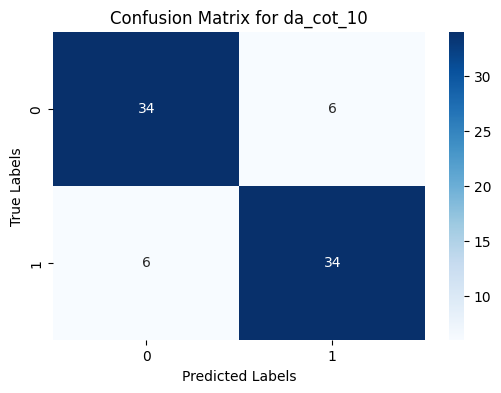

Results for metric da_cot_10:
{
    "Precision (Class 0)": 0.85,
    "Precision (Class 1)": 0.85,
    "Recall (Class 0)": 0.85,
    "Recall (Class 1)": 0.85,
    "F1 Score (Class 0)": 0.85,
    "F1 Score (Class 1)": 0.85,
    "F1 Score Mean": 0.85,
    "Pearson Corr": 0.7,
    "accuracy": 0.85
}


In [9]:
# Loop through each metric and calculate confusion matrix, precision, recall, and F1 score
for metric in metrics:
    try:
        if metric in df.columns:
            metric_series = df[metric]
            #check if is discrete (0 or 1)
            if metric_series.nunique() != 2:
                continue
            evaluate_metric(metric, metric_series)
    except Exception as e:
        print(f"Could not calculate for metric: {metric}")


### Continuous metric

Results for metric da_cot_10_score with all thresholds:
limits acc: [0.7625, 0.7625, 0.8125, 0.8125, 0.8375, 0.85, 0.7]


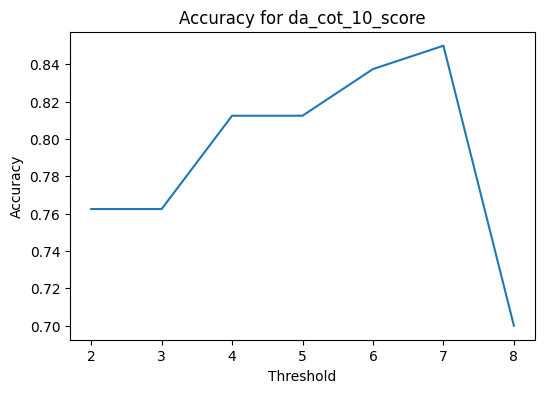

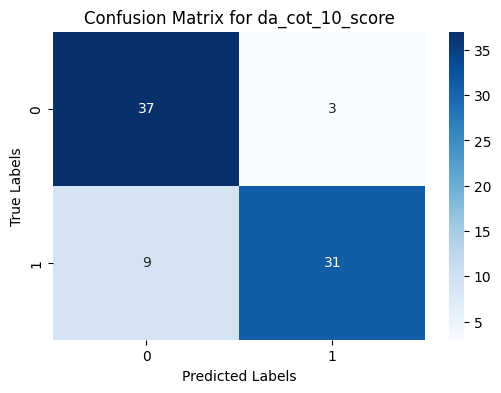

Results for metric da_cot_10_score:
{
    "Precision (Class 0)": 0.8043478260869565,
    "Precision (Class 1)": 0.9117647058823529,
    "Recall (Class 0)": 0.925,
    "Recall (Class 1)": 0.775,
    "F1 Score (Class 0)": 0.8604651162790697,
    "F1 Score (Class 1)": 0.8378378378378378,
    "F1 Score Mean": 0.8491514770584538,
    "Pearson Corr": 0.7080104323938434,
    "accuracy": 0.85
}


In [4]:
for metric in metrics:
    try:
        if metric in df.columns:
            limits_acc = []
            if df[metric].max() > 1.0:
                limits = [2, 3, 4, 5, 6, 7, 8]
            else:
                limits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
            if df[metric].nunique() == 2:
                continue

            for limit in limits:
                metric_series = df[metric]
                metric_series = (metric_series > limit).astype(int)
                limits_acc.append(evaluate_metric(metric, metric_series, verbose=False)["accuracy"])

            print(f"Results for metric {metric} with all thresholds:")
            print(f"limits acc: {limits_acc}")
            # Plot line chart with seaborn
            plt.figure(figsize=(6, 4))
            sns.lineplot(x=limits, y=limits_acc)
            plt.title(f'Accuracy for {metric}')
            plt.xlabel('Threshold')
            plt.ylabel('Accuracy')
            plt.show()

            # Plot confusion matrix of best metric
            best_limit = limits[limits_acc.index(max(limits_acc))]
            metric_series = df[metric]
            metric_series = (metric_series > best_limit).astype(int)
            evaluate_metric(metric, metric_series)
    except Exception as e:
        print(f"Could not calculate for metric: {metric}")

# Plots

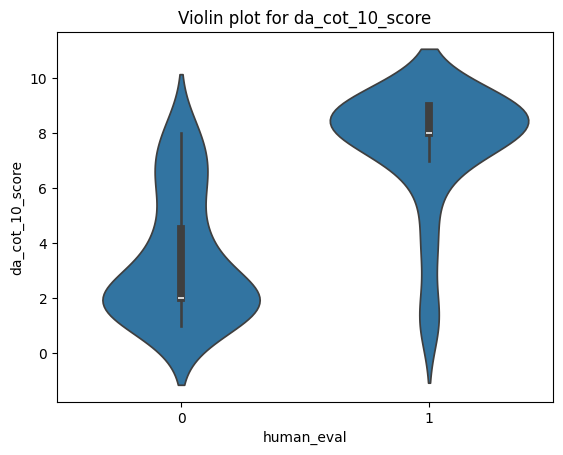

In [5]:
# Plot violin seaborn depending if human_eval = 1 or = 0

for metric in metrics:
    try:
        if metric in df.columns:
            metric_series = df[metric]
            #check if is discrete (0 or 1)
            if metric_series.nunique() == 2:
                continue
            sns.violinplot(x="human_eval", y=metric, data=df)
            plt.title(f'Violin plot for {metric}')
            plt.xlabel('human_eval')
            plt.ylabel(metric)
            plt.show()
    except Exception as e:
        print(f"Could not calculate for metric: {metric}")